# Two way partitioning problem

## Naive approach

In [5]:
import numpy as np

n = 10
W = 10*np.random.randn(n,n)
W = (W + W.T)/2

def brute_force_optimisation(W):
    n = W.shape[0]
    opt_obj = np.inf
    opt_x = np.inf * np.ones(n)
    elements = list(range(n))
    subsets = [[]]

    for el in elements:
        for i in range(len(subsets)):
            subsets += [subsets[i]+[el]]
            x = np.ones(n)
            x[subsets[-1]] = -1
            obj_val = x.T @ W @ x
            if obj_val < opt_obj:
                opt_obj = obj_val
                opt_x = x

    return opt_obj, opt_x

In [13]:
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
np.random.seed(1)
times = []

ns = list(range(1,18))

for n in tqdm(ns):
  W = np.random.randn(n,n)
  W = (W + W.T)/2
  
  res = %timeit -r 3 -n 3 -o -q brute_force_optimisation(W)

  times.append(res.average)

100%|██████████| 17/17 [00:23<00:00,  1.41s/it]


Estimated n, which will take universe lifetime is 59


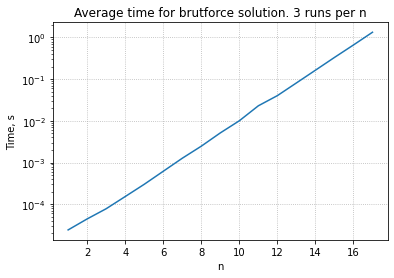

In [14]:
plt.semilogy(ns, times)
plt.xlabel('n')
plt.ylabel('Time, s')
plt.grid(True, ls=':')
plt.title('Average time for brutforce solution. 3 runs per n')
plt.savefig('lls_times.svg')
universe_lifetime = 4.4e17
n_exp = int(np.log(universe_lifetime)/(np.log(times[-1]) - np.log(times[0]))*(ns[-1] - ns[0]))
print(f"Estimated n, which will take universe lifetime is {n_exp}")
plt.savefig('partition_bruteforce.svg')

## Simple lower bound with duality

In [19]:
def simple_lower_bound(W):
    n = W.shape[0]
    return min(np.linalg.eig(W)[0])*n

opt_obj, _ = brute_force_optimisation(W)
lower_bound = simple_lower_bound(W)
print(f"🦄 Optimal function value {opt_obj:.2f}")
print(f"😱 Trivial lower bound with minimal eigenvalue {lower_bound:.2f}")

🦄 Optimal function value -58.41
😱 Trivial lower bound with minimal eigenvalue -96.56


## Optimal lower bound with cvxpy

In [80]:
import cvxpy as cp

def dual_problem_solution(W):
    n = W.shape[0]
    nu = cp.Variable(n)
    obj = -np.ones(n).T @ nu
    constraints = [W + cp.diag(nu) >> 0]
    prob = cp.Problem(cp.Maximize(obj), constraints)
    prob.solve()
    return prob

p = dual_problem_solution(W)
print(f"🦄 Optimal function value {opt_obj:.2f}")
print(f"😱 Trivial lower bound with minimal eigenvalue {lower_bound:.2f}")
print(f"🃏 Optimal lower bound from CVXPY solver {p.value:.2f}")

🦄 Optimal function value -58.41
😱 Trivial lower bound with minimal eigenvalue -96.56
🃏 Optimal lower bound from CVXPY solver -63.01


## Power method with shifts for the $\lambda_{min}$ estimation

As soon as Power method is able to rethrieve an eiginvalue with the highest absolute value, we need to ensure, that minimal eigenvalue will be the highest in absolute value.

In [78]:
def power_method(W, n_iter=10):
    n = W.shape[0]
    x = np.random.randn(n)
    for i in range(n_iter):
        x_norm = np.linalg.norm(x)
        Wx = W @ x
        Wx_norm = np.linalg.norm(Wx)
        lamb = Wx_norm/x_norm
        x = Wx/x_norm
    
    return lamb

def power_method_with_shifts(W, n_iter=100):
    n = W.shape[0]
    # First, we estimate lambda_max, assuming it's positive number.
    shift = power_method(W, 5)

    # Then, we create a matrix with spectrum, shifted to the left
    W_shifted = W - shift*np.eye(n)

    # And apply power method to estimate absolute value of maximum eigenvalue
    lamb_shifted = power_method(W_shifted, n_iter)

    lambda_min = -lamb_shifted + shift

    return lambda_min

In [86]:
print(f"🐱 Minimum eigenvalue estimation with Power Method with shifts is {power_method_with_shifts(W):.3f}")
print(f"💩 Minimum eigenvalue from np.linalg.svd {min(np.linalg.eig(W)[0]):.3f}")

🐱 Minimum eigenvalue estimation with Power Method with shifts is -5.680
💩 Minimum eigenvalue from np.linalg.svd -5.680
